In [1]:
import numpy as np
import pandas as pd 
import tensorflow as tf
import nltk
import seaborn as sns
import re
import matplotlib.pyplot as plt
from tqdm import tqdm

from tensorflow.keras.layers import Embedding, Dense, LSTM, Dropout, Bidirectional
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import one_hot, Tokenizer
from tensorflow.keras.callbacks import ModelCheckpoint
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [18]:
# Raw data from twitter reddit and from around the web
raw_data = pd.read_csv('combined_data.csv')

# Pre-trained Embeddings
EMBEDDING_FILE = f'glove.6B.100d.txt'
raw_data.head(-10)

# 270K rows

,Unnamed: 0,Text,Emotion
0,0,That game hurt.,sadness
1,1,"You do right, if you don't care then fuck 'em!",neutral
2,2,Man I love reddit.,love
3,3,"[NAME] was nowhere near them, he was by the Fa...",neutral
4,4,Right? Considering it’s such an important docu...,happy
...,...,...,...
269258,269258,"Effortlessly , his knee slid to part her legs ...",fear
269259,269259,The commercial ethic meant some deterioration ...,fear
269260,269260,This caused a good deal of consternation and d...,fear
269261,269261,And it was equally insistent that a policy of ...,fear


C:\Users\Elusive\.conda\envs\ML\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Emotion', ylabel='count'>

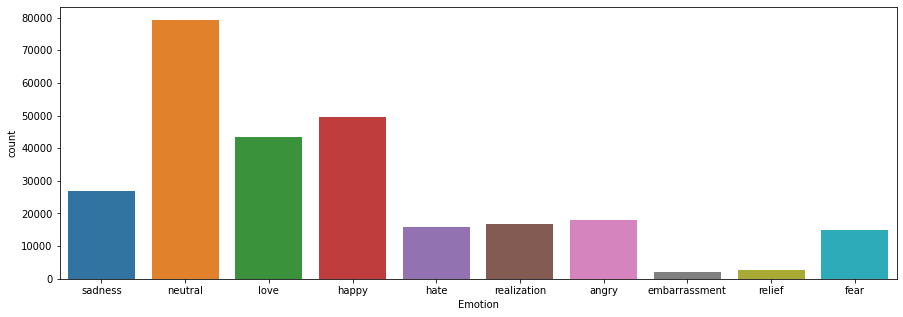

In [19]:
# Target Classes (Labels)
plt.figure(figsize=(15,5))

sns.countplot(raw_data['Emotion'])

In [21]:
# Drop columns with NA values
raw_data = raw_data.dropna() 

X = raw_data.drop('Emotion', axis=1) #input
y = raw_data['Emotion'] #output

messages = X.copy()
# Reset index after droping null columns
messages.reset_index(inplace=True) 

In [22]:
nltk.download('stopwords')
ps = PorterStemmer()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Elusive\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [14]:
# Preparing the corpus (cleaning the data)
corpus = []
for i in tqdm(range(0, len(messages))):
    review = re.sub('[^a-zA-Z]', ' ', messages['Text'][i]) #Remove Special Characters
    review = review.lower() #Lower case 
    review = review.split()
    review = [ps.stem(word) for word in review if not word in stopwords.words('english')] #Remove stopwords
    review = ' '.join(review)
    corpus.append(review)

100%|██████████| 269273/269273 [09:36<00:00, 467.23it/s]


In [39]:
# Saving Progress
if len(corpus) > 100000:
    corpus_df = pd.DataFrame({'Text': corpus})
    corpus_df.to_csv('corpus.csv')
print(len(corpus))
corpus[-10:]

269273


['edouard look felt sicken dism',
 'tina children move school cecilia felt dismay guilti reli',
 'felt dismay sorrow mani peopl countri share person good fortun',
 'stare one anoth dismay sad small wicked friend neighbour strewn around mind like dirti confetti parti long pa',
 'cleo stare content dism',
 'melissa stare friend dism',
 'success state elect seen govern parti pummel dismay electora',
 'vincent irrit dismay',
 'kendal hume turn back face dismay coup',
 'dismay surpri']

In [30]:
# Loading Progress
temp = pd.read_csv('corpus.csv')
temp['Emotion'] = raw_data['Emotion'].values
temp['Text'] = temp['Text'].str.replace('\d+', '')
temp = temp.dropna()
temp_list = temp['Text'].tolist()
print(len(temp_list))
temp_list[-10:]

<ipython-input-30-7ce3f7d210df>:4: FutureWarning: The default value of regex will change from True to False in a future version.
  temp['Text'] = temp['Text'].str.replace('\d+', '')
268737


['edouard look felt sicken dism',
 'tina children move school cecilia felt dismay guilti reli',
 'felt dismay sorrow mani peopl countri share person good fortun',
 'stare one anoth dismay sad small wicked friend neighbour strewn around mind like dirti confetti parti long pa',
 'cleo stare content dism',
 'melissa stare friend dism',
 'success state elect seen govern parti pummel dismay electora',
 'vincent irrit dismay',
 'kendal hume turn back face dismay coup',
 'dismay surpri']

In [31]:
X = temp.drop('Emotion', axis=1) #input
y = temp['Emotion'] #output

In [32]:
corpus = []
corpus = temp_list
print(len(corpus))
corpus[-10:]

268737


['edouard look felt sicken dism',
 'tina children move school cecilia felt dismay guilti reli',
 'felt dismay sorrow mani peopl countri share person good fortun',
 'stare one anoth dismay sad small wicked friend neighbour strewn around mind like dirti confetti parti long pa',
 'cleo stare content dism',
 'melissa stare friend dism',
 'success state elect seen govern parti pummel dismay electora',
 'vincent irrit dismay',
 'kendal hume turn back face dismay coup',
 'dismay surpri']

In [33]:
# Creating the dictionary with word as key and pretrained-value array as value
def get_coefs(word,*arr):
    return word, np.asarray(arr, dtype='float32')

embeddings_index = dict(get_coefs(*o.strip().split()) for o in open(EMBEDDING_FILE, encoding="utf8"))


# Calculate MEAN and Standard-Deviation for the pre-trained weights
all_embeddings = np.stack(embeddings_index.values())
embedding_mean, embedding_std = all_embeddings.mean(), all_embeddings.std()
print(embedding_mean, embedding_std)

C:\Users\Elusive\.conda\envs\ML\lib\site-packages\IPython\core\interactiveshell.py:3357: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  if (await self.run_code(code, result,  async_=asy)):
0.004451992 0.4081574


In [34]:
vocabulary_size = 50000
# Word vector size
embed_size = 100 

tokenizer = Tokenizer(num_words = vocabulary_size)
tokenizer.fit_on_texts(list(corpus))

In [35]:
word_index = tokenizer.word_index #Total words in the corpus
nb_words = min(vocabulary_size, len(word_index))

In [36]:
# Initialize weight matrix for embedding layer
embedding_matrix = np.random.normal(embedding_mean, embedding_std, (nb_words, embed_size)) 

for word, i in word_index.items():
    if i >= vocabulary_size:
        continue #skip the words if vocab size is reached
    embedding_vector = embeddings_index.get(word) #extracting the pre-trained values from GloVe
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [37]:
# Contains the pretrained GloVe weights for the words
len(embedding_matrix)

50000

In [38]:
# One hot representation for input
onehot_repr = [one_hot(words, vocabulary_size) for words in corpus]

# Finding max words
l = 0
for x in tqdm(corpus):
    l = max(l, len(x.split(' ')))

#Padding the sequences for input
sentence_length = l
embedded_docs = pad_sequences(onehot_repr, padding = 'pre', maxlen = sentence_length)
print(embedded_docs)

100%|██████████| 268737/268737 [00:00<00:00, 1421651.19it/s]
[[    0     0     0 ...     0 34993 19720]
 [    0     0     0 ... 44816 37604 25797]
 [    0     0     0 ... 40756 11083 13986]
 ...
 [    0     0     0 ...  5802   514 11998]
 [    0     0     0 ... 39043 11998 34682]
 [    0     0     0 ...     0 11998  5329]]


In [39]:
# Encoding the target outputs to integers
label_encoder = preprocessing.LabelEncoder()

X_final = np.array(embedded_docs) #input to array
y = label_encoder.fit_transform(y)
y_final = np.array(y)
print(y_final)

X_final.shape, y_final.shape

[9 6 5 ... 2 2 2]


((268737, 35), (268737,))

In [40]:
# Train-Test split
X_train, X_test, y_train, y_test = train_test_split(X_final, y_final, test_size=0.2, random_state=42)

# Train-Validation split
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=21)

In [42]:
# Creating model
model=Sequential()
model.add(Embedding(vocabulary_size, embed_size, weights=[embedding_matrix]))
model.add(Dropout(0.3))
model.add(Bidirectional(LSTM(64)))
model.add(Dropout(0.3))
model.add(Dense(64, activation='relu', kernel_regularizer = tf.keras.regularizers.l1(0.01))) # L1 regularization
model.add(Dropout(0.3))
model.add(Dense(10,activation='softmax'))
model.compile(loss='sparse_categorical_crossentropy',optimizer= tf.keras.optimizers.Adam(learning_rate=0.001),
              metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 100)         5000000   
_________________________________________________________________
dropout (Dropout)            (None, None, 100)         0         
_________________________________________________________________
bidirectional (Bidirectional (None, 128)               84480     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 64)                8256      
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)               

In [43]:
model_save = ModelCheckpoint('weights.h5', save_best_only = True, save_weights_only = True, monitor = 'val_loss', mode = 'min', verbose = 1)

history = model.fit(X_train, y_train, validation_data = (X_val, y_val), epochs = 50, batch_size = 64, callbacks = [model_save])

Epoch 1/50
3024/3024 [==============================] - 115s 37ms/step - loss: 2.1213 - accuracy: 0.3286 - val_loss: 1.8563 - val_accuracy: 0.3860

Epoch 00001: val_loss improved from inf to 1.85632, saving model to weights.h5
Epoch 2/50
3024/3024 [==============================] - 111s 37ms/step - loss: 1.8103 - accuracy: 0.4128 - val_loss: 1.7080 - val_accuracy: 0.4628

Epoch 00002: val_loss improved from 1.85632 to 1.70799, saving model to weights.h5
Epoch 3/50
3024/3024 [==============================] - 110s 37ms/step - loss: 1.7245 - accuracy: 0.4503 - val_loss: 1.6717 - val_accuracy: 0.4681

Epoch 00003: val_loss improved from 1.70799 to 1.67172, saving model to weights.h5
Epoch 4/50
3024/3024 [==============================] - 113s 37ms/step - loss: 1.6818 - accuracy: 0.4639 - val_loss: 1.6477 - val_accuracy: 0.4795

Epoch 00004: val_loss improved from 1.67172 to 1.64773, saving model to weights.h5
Epoch 5/50
3024/3024 [==============================] - 113s 37ms/step - loss: 1

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


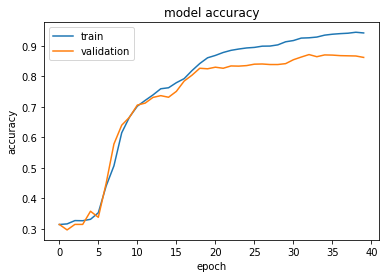

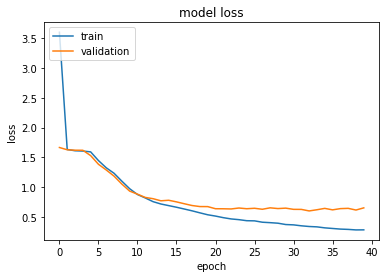

In [21]:
print(history.history.keys())
#  "Accuracy"
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [22]:
#Load the best weights
model.load_weights('weights.h5')

In [23]:
y_pred = model.predict_classes(X_test)
print(y_pred)

C:\Users\Elusive\.conda\envs\ML\lib\site-packages\tensorflow\python\keras\engine\sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
[2 0 4 ... 0 0 4]


In [24]:
#Accuracy score
print(accuracy_score(y_test,y_pred))

0.874650512581547


In [25]:
#Classification report
print(classification_report(y_test, y_pred, digits=5))

              precision    recall  f1-score   support

           0    0.86020   0.84765   0.85388       617
           1    0.80382   0.87194   0.83650       531
           2    0.91507   0.89718   0.90603      1381
           3    0.72477   0.74528   0.73488       318
           4    0.91686   0.93265   0.92469      1277
           5    0.78906   0.60119   0.68243       168

    accuracy                        0.87465      4292
   macro avg    0.83496   0.81598   0.82307      4292
weighted avg    0.87492   0.87465   0.87405      4292



Confusion Matrix
AxesSubplot(0.125,0.125;0.62x0.755)


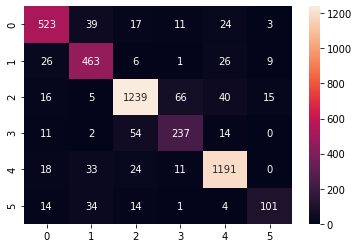

In [26]:
#Confusion Matrix
print('Confusion Matrix')
print(sns.heatmap(confusion_matrix(y_test, y_pred),annot=True,fmt="d"))

In [49]:
#Mapping of target classes using label-encoder
le_name_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
le_name_mapping = {'anger': 0, 'fear': 1, 'happy': 2, 'love': 3, 'sadness': 4, 'surprise': 5}
print(le_name_mapping)

emotional_class_mapping = []
for item in le_name_mapping.items():
    # print(key)
    emotional_class_mapping.append(item[0])

print(emotional_class_mapping)

{'anger': 0, 'fear': 1, 'happy': 2, 'love': 3, 'sadness': 4, 'surprise': 5}
['anger', 'fear', 'happy', 'love', 'sadness', 'surprise']


In [50]:
def predict_emotion(stri):
    review = re.sub('[^a-zA-Z]', ' ', stri)
    review = review.lower()
    review = review.split()
    review = [ps.stem(word) for word in review if not word in stopwords.words('english')]
    review = ' '.join(review)
    onehot_repr = [one_hot(review,voc_size)] 
    embed = pad_sequences(onehot_repr,padding='pre',maxlen=sent_length)
    predicti = model.predict(embed)
    return emotional_class_mapping[np.argmax(predicti)]

In [51]:
predict_emotion('I am very happy and joyful today')

'happy'

In [61]:
predict_emotion('He is an arrogant and rude person')

'anger'

In [65]:
predict_emotion('The teacher is intimidating and scary')

'fear'